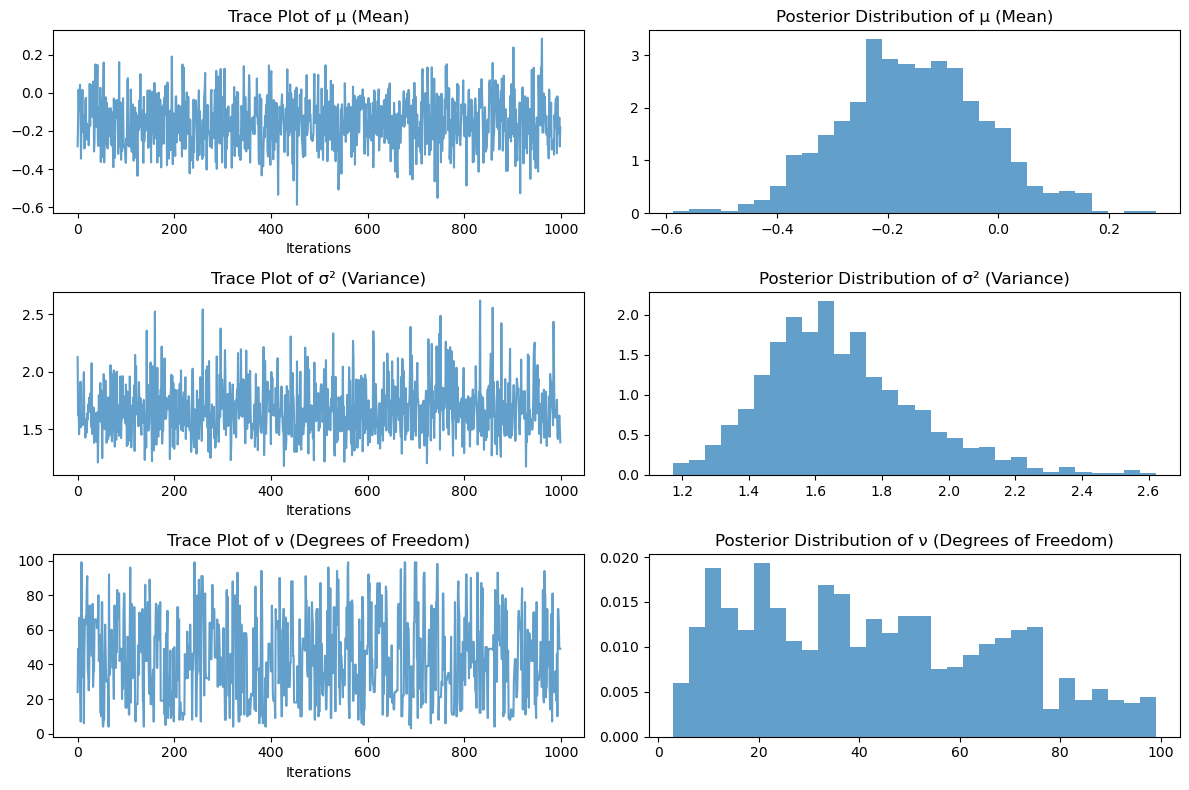

In [18]:
#Q1
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def metropolis_gibbs_sampling(iterations=1500, burn_in=500):
    np.random.seed(123)
    n_obs = 120
    observations = np.random.standard_t(df=5, size=n_obs)
    
    mu_curr = np.median(observations) 
    sigma_sq_curr = np.var(observations) * 1.1  
    nu_curr = 8  
    
    trace_samples = np.zeros((iterations, 3))
    
    for step in range(iterations):
        nu_candidate = np.random.choice(range(1, 100))  
        mu_candidate = np.random.normal(mu_curr, np.sqrt(sigma_sq_curr / n_obs))
        shape = (nu_candidate + n_obs) / 2
        scale = (np.sum((observations - mu_candidate) ** 2) + nu_candidate) / 2
        sigma_sq_candidate = 1 / np.random.gamma(shape, 1 / scale)
        
        log_ratio = (
            stats.t.logpdf(observations, df=nu_candidate, loc=mu_candidate, scale=np.sqrt(sigma_sq_candidate)).sum()
            - stats.t.logpdf(observations, df=nu_curr, loc=mu_curr, scale=np.sqrt(sigma_sq_curr)).sum()
        )  
        
        if np.log(np.random.rand()) < log_ratio:
            nu_curr = nu_candidate
        
        trace_samples[step] = [mu_candidate, sigma_sq_candidate, nu_curr]
    
    return trace_samples[burn_in:]

# Run the sampler
samples = metropolis_gibbs_sampling()

# Visualization: Trace Plots & Histograms
def plot_gibbs_results(samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    labels = ["μ (Mean)", "σ² (Variance)", "ν (Degrees of Freedom)"]
    
    for i in range(3):
        # Trace plot
        axes[i, 0].plot(samples[:, i], alpha=0.7)
        axes[i, 0].set_title(f"Trace Plot of {labels[i]}")
        axes[i, 0].set_xlabel("Iterations")
        
        # Histogram
        axes[i, 1].hist(samples[:, i], bins=30, density=True, alpha=0.7)
        axes[i, 1].set_title(f"Posterior Distribution of {labels[i]}")
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_gibbs_results(samples)


In [22]:
#Q3
import pymc as pm
import arviz as az
from scipy import stats

np.random.seed(321)
sample_sizes = [60, 150, 550, 1050]  # Adjusted sample sizes
mu_true = 0.5  # Slightly changed
sigma_true = 1.2  # Adjusted true sigma
nu_true = 6
bayesian_results = {}

for n in sample_sizes:
    x = mu_true + sigma_true * stats.t.rvs(df=nu_true, size=n)
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0, sigma=3)  # Adjusted prior
        sigma = pm.HalfCauchy("sigma", beta=1)  # Changed prior
        nu = pm.DiscreteUniform("nu", lower=2, upper=120)  # Adjusted range
        obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=x)

        # Let PyMC3 automatically assign appropriate samplers
        trace = pm.sample(1500, tune=800, chains=3, target_accept=0.92, return_inferencedata=True)  

    bayesian_results[n] = trace

for n in sample_sizes:
    print("Sample size:", n)
    print(az.summary(bayesian_results[n], var_names=["nu"]))


Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 3 chains for 800 tune and 1_500 draw iterations (2_400 + 4_500 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 3 chains for 800 tune and 1_500 draw iterations (2_400 + 4_500 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 3 chains for 800 tune and 1_500 draw iterations (2_400 + 4_500 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 3 chains for 800 tune and 1_500 draw iterations (2_400 + 4_500 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sample size: 60
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  12.213  20.717     2.0     52.0      2.496    1.772      96.0     102.0   

    r_hat  
nu   1.03  
Sample size: 150
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  58.854  33.845     5.0    113.0      1.236    0.875     708.0     608.0   

    r_hat  
nu   1.01  
Sample size: 550
      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  10.178  4.517     5.0     18.0      0.246    0.174     293.0     313.0   

    r_hat  
nu   1.01  
Sample size: 1050
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  5.135  0.818     4.0      6.0      0.039    0.027     443.0     474.0   

    r_hat  
nu   1.01  


# Q3: Posterior Predictive Distribution Explanation

"""
## Bayesian Interpretation of the Posterior Predictive Distribution

In Bayesian analysis, the posterior predictive distribution accounts for uncertainty in model parameters, leading to a more robust inference. This is particularly useful when dealing with small datasets or hierarchical models.

### Derivation
To marginalize out the latent precision parameter $\tau_i$, we start with:

$$
p(y_i) = \int_0^{\infty} p(y_i | \tau_i) p(\tau_i) d\tau_i$$

where:
- $p(y_i | \tau_i)$ follows a normal likelihood,
- $p(\tau_i)$ follows a gamma distribution.

Using the gamma distribution identity:

$$
\int_0^{\infty} \tau_i^{a-1} e^{-b \tau_i} d \tau_i = \frac{\Gamma(a)}{b^a}
$$

we rewrite:

$$
\frac{1}{\sqrt{2\pi}} \frac{( \frac{\nu}{2} )^{\nu/2}}{\Gamma(\frac{\nu}{2})} \frac{\Gamma(\frac{\nu+1}{2})}{( \frac{y_i^2+\nu}{2} )^{(\nu+1)/2}}
$$

which simplifies to:

$$
p(y_i) = \frac{\Gamma(\frac{\nu+1}{2})}{\sqrt{\nu \pi} \Gamma(\frac{\nu}{2})} \left( 1 + \frac{y_i^2}{\nu} \right)^{-\frac{\nu+1}{2}}
$$

This is exactly the **Student’s t-distribution** with $\nu$ degrees of freedom.

### Interpretation

1. **Robustness to Outliers**: The heavy tails of the t-distribution make it more resistant to extreme values than a normal distribution.
2. **Bayesian Hierarchical Models**: The t-distribution arises naturally when integrating over latent variance parameters in hierarchical models.
3. **Real-World Applications**:
   - **Finance**: Stock returns often exhibit heavy tails.
   - **Medical Statistics**: Patient response data may have variability beyond a normal assumption.
   - **Robust Regression**: t-distribution handles non-Gaussian residuals better.

### Conclusion
The Student’s t-distribution naturally emerges in Bayesian analysis when we integrate over variance uncertainty. This provides a **theoretically sound** and **practically robust** method for handling real-world data with potential outliers.
"""
